<a href="https://colab.research.google.com/github/HagerDakroury/handwritten-digits-classification/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

#mounting my google drive where the dataset is saved
#can be done like that or directly from google colab UI

# from google.colab import drive
# drive.mount('/content/drive')

#extracting the dataset
!tar xvzf /content/drive/MyDrive/trainingSet.tar.gz




In [38]:
def Load_data(directory):
  
  """
    load the dataset from a directory and split it into train and validation sets
    :param directory: path to the directory containing the dataset 
    :return t_dataset: train dataset. A tf.data.Dataset object
    :return v_dataset: validation dataset. A tf.data.Dataset object
  """ 


  #fitting the data into a dataset
  #image_size=(28,28)
  #training to validation ratio 8:2
  #seed is random

  #the training dataset
  t_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      directory, labels='inferred',label_mode='int',color_mode='rgb',
      batch_size=32, image_size=(28,28), validation_split=0.2,
      subset="training",seed=387
  )

  #the validation dataset 
  v_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      directory, labels='inferred',label_mode='int', color_mode='rgb',
      batch_size=32, image_size=(28,28), validation_split=0.2,
      subset="validation",seed=387
  )

  return t_dataset,v_dataset


In [43]:
#trainig the CNN model
#takes the train and validation dat

def train(t_dataset,v_dataset):

  """
    train function that trains the CNN model and save it
    :param t_dataset: train dataset. A tf.data.Dataset object
    :param v_dataset: validation dataset. A tf.data.Dataset object
  """ 
  
  #keeping the data into memory after they're loaded to avoid I/O blocking
  AUTOTUNE = tf.data.AUTOTUNE

  t_ds = t_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  v_ds = v_dataset.cache().prefetch(buffer_size=AUTOTUNE)

  #resclaing the dataset
  normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

  t_ds = t_ds.map(lambda x, y: (normalization_layer(x), y))
  v_ds = v_ds.map(lambda x, y: (normalization_layer(x), y))

  #constructing the model
  #layer1-> input shape:(28,38,3)  output shape:(26,26,32) description: 2D convolutional layers with 32 filters
  #layer2-> input shape:(26,26,32) output shape:(13,13,32) description: A max pooling layer
  #layer3-> input shape:(13,13,32) output shape:(5498,0,0) description: A Flatten Layer
  #layer4-> input shape:(5498,0,0) output shape:(100,0,0)  description: A Dense Layer with Relu activation
  #layer5-> input shape:(100,0,0)  output shape:(10,0,0)   description: A Dense Layer  (final layer)
  model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(100, activation='relu', kernel_initializer='he_uniform'),
    layers.Dense(10)
  ])

  #compiling model
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  #fitting the model
  epochs=10
  history = model.fit(
    t_ds,
    validation_data=v_ds,
    epochs=epochs
  )

  #checking accuracy
  val_acc = history.history['val_accuracy']
  print('> %.3f' % (val_acc[9] * 100.0))

  #saving the model
  model.save('/content/My Drive/cse440_project/model.h5')


  #A quick check of the model 
  class_names = t_dataset.class_names 
  plt.figure(figsize=(9, 9))
  for images, labels in t_dataset.take(1):
      for i in range(9):
          ax = plt.subplot(3, 3, i + 1)
          plt.imshow(images[i].numpy().astype("uint8"))
          #predicting the image 
          predict=Predict(isPath=False,image=images[i])
          plt.title("true:"+"["+class_names[labels[i]]+"]  "+"predicted:"+np.array_str(predict))

          plt.axis("off")



In [45]:
from keras.models import load_model

def Predict(isPath,image_path=None,image=None):
  """
    predict the image from the saved model
    either loads the imgae from the path or work on a pre-loaded image
    :param isPath: specifying whether the passed parameter is image path or image object
    :param image_path: the image path (optional)
    :param image: the image object (optional)
    :return predict: the predicted class
  """ 

  if isPath:
    img=load_img(image_path,target_size=(28,28))
    
  else:
    img=image
  
  #some preprocessing so the image is ready
  img = img_to_array(img)
  img = img.reshape(1, 28, 28, 3)
  img = img.astype('float32')
  img = img / 255.0

  #loading the model
  model=load_model('/content/My Drive/cse440_project/model.h5')


  #the prediction
  predict=np.argmax(model.predict(img),axis=-1)
  print("prediction is: "+np.array_str(predict))

  return predict

  




In [49]:

import logging
tf.get_logger().setLevel(logging.ERROR)



Predict(isPath=True,image_path="/content/trainingSet/7/img_10028.jpg")


prediction is: [7]


array([7])

Found 42000 files belonging to 10 classes.
Using 33600 files for training.
Found 42000 files belonging to 10 classes.
Using 8400 files for validation.
Epoch 1/10
1050/1050 [==============================] - 66s 24ms/step - loss: 0.3101 - accuracy: 0.9043 - val_loss: 0.0827 - val_accuracy: 0.9755
Epoch 2/10
1050/1050 [==============================] - 23s 22ms/step - loss: 0.0502 - accuracy: 0.9851 - val_loss: 0.0617 - val_accuracy: 0.9830
Epoch 3/10
1050/1050 [==============================] - 22s 21ms/step - loss: 0.0276 - accuracy: 0.9911 - val_loss: 0.0679 - val_accuracy: 0.9802
Epoch 4/10
1050/1050 [==============================] - 22s 21ms/step - loss: 0.0138 - accuracy: 0.9956 - val_loss: 0.0612 - val_accuracy: 0.9825
Epoch 5/10
1050/1050 [==============================] - 22s 21ms/step - loss: 0.0129 - accuracy: 0.9955 - val_loss: 0.0705 - val_accuracy: 0.9819
Epoch 6/10
1050/1050 [==============================] - 22s 21ms/step - loss: 0.0062 - accuracy: 0.9984 - val_loss: 0.0

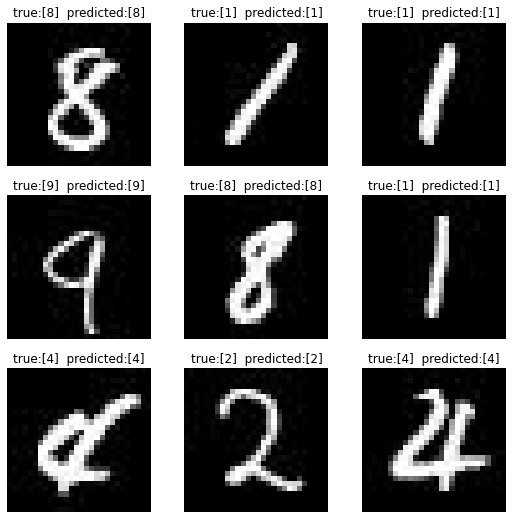

In [50]:
t_dataset,v_dataset=Load_data("/content/trainingSet")
train(t_dataset,v_dataset)